In [1]:
from flax import nnx
from flax import linen
import jax
import jax.numpy as jnp
import torch
import os
from pytorch_model import UNET2D
from jax_unet import unet

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import utils.utilities as ut
from models import time_integration
from torch.utils.data import DataLoader
from dataset.dataset_nemo import preprocess_data
from models import networks as net

from jax import ops

import logging
from src.nnUtils import autoregressive
import io
import re
log = logging.getLogger(__name__)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {DEVICE}")


Running on: cpu


In [2]:
# Initialize model parameters
num_layers = 5
in_channels = [3, 2]  # [dynamics_channels, statics_channels]
out_channels = 3
features = [16, 32, 64, 128, 256]
kernel_size = (3, 3)
stride = 1
padding = 1
# Create model
model = unet(
    num_layers=num_layers,
    in_channels=in_channels,
    out_channels=out_channels,
    features=features,
    kernel_size=kernel_size,
    stride=stride,
    padding=padding,
)

# # Create sample input data
# batch_size = 1
# height, width = 100, 100
# x = jnp.ones((1, height, width, in_channels[0]))  # Dynamic input
# H = jnp.ones((1, height, width, 1))  # Static terrain
# mask = jnp.ones((1, height, width, 1))  # Binary mask

# # Pass data through model
# output = model(x, H=H, mask=mask)
# print(f"Jax model total parameters: {model.total_params()}")
# model.summary()
model.load_torch_weights()

# print(f"Input shape: {x.shape}")
# print(f"Output shape: {output.shape}")
# print(f"Expected output channels: {out_channels}")

print(model)

DEVICE on Loading model:  cpu
+++++++++++++++++++ LOADING trained model ++++++++++++++++++++++++++
=== PyTorch Model Parameter Counts ===
dynamics.weight: 216 parameters
dynamics.bias: 8 parameters
statics.weight: 144 parameters
statics.bias: 8 parameters
encoder.0.conv.0.weight: 2,304 parameters
encoder.0.conv.0.bias: 16 parameters
encoder.0.conv.1.weight: 16 parameters
encoder.0.conv.1.bias: 16 parameters
encoder.0.conv.3.weight: 2,304 parameters
encoder.0.conv.3.bias: 16 parameters
encoder.1.conv.0.weight: 4,608 parameters
encoder.1.conv.0.bias: 32 parameters
encoder.1.conv.1.weight: 32 parameters
encoder.1.conv.1.bias: 32 parameters
encoder.1.conv.3.weight: 9,216 parameters
encoder.1.conv.3.bias: 32 parameters
encoder.2.conv.0.weight: 18,432 parameters
encoder.2.conv.0.bias: 64 parameters
encoder.2.conv.1.weight: 64 parameters
encoder.2.conv.1.bias: 64 parameters
encoder.2.conv.3.weight: 36,864 parameters
encoder.2.conv.3.bias: 64 parameters
encoder.3.conv.0.weight: 73,728 paramete

In [3]:

CONDI_NET           = False
# NETWORK             = "UNETSWEv4"
# FORWARD_MODEL       = "ForwardEulerConstraintBC"
NETWORK             = "UNET2D"
FORWARD_MODEL       = "ForwardEuler"
DT                  = 300
# EXP_NAME          = "unet_closedbc_swe_scaleddata_exp2"
EXP_NAME            = "unet_closedbc_swe_std_exp6"
TESTCASE            = "swe"
NORMALIZE           = True
# NORMALIZE_TYPE      = "scale"
NORMALIZE_TYPE      = "std"
# PATH_TO_FILE      = "/work/gg0028/g260225/dev/diff-ocean-nemo/data/swe/smalldataset_dt300.npz"
wkdir               = "/home/minh/coding/dev/machinelearning/diff-ocean-nemo"
PATH_TO_FILE        = f"{wkdir}/data/swe/swe_d15_1data_100x100_dt300.npz"
SAVE_FWD_DIR        = f"{wkdir}/saved/forward"
FWD_EXP_DIR         = f"{SAVE_FWD_DIR}/{EXP_NAME}"
pathfile            = f"{FWD_EXP_DIR}/model.pth.tar"
folder_saving = FWD_EXP_DIR
CONSTRAINT_BC       = True


network_params = {
    'name': 'UNET2D',
    'condi_net': False,
    'in_channels': [3, 2],
    'out_channels': [3],
    'features': [16, 32, 64, 128, 256],
    'kernel_size': 3,
    'stride': 1,
    'padding': 1,
    'norm_type': 'GroupNorm',
    'activation': 'SiLU',
    'num_layers': 5,
}

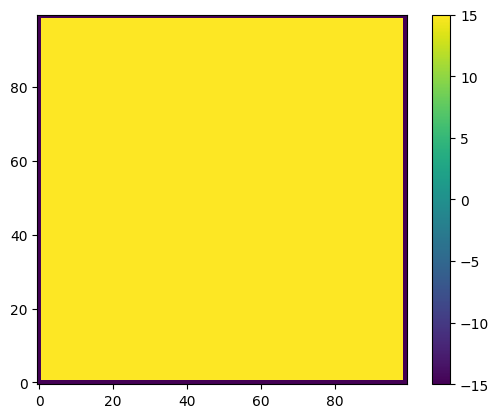

ssh.shape =  (1, 301, 100, 100)


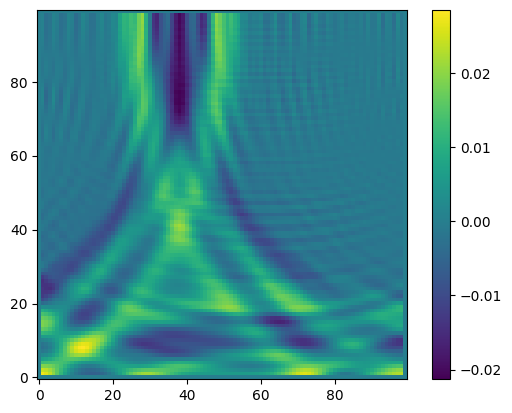

x0_mean:  5.4975302e-05
x0_std:  1.0005038
x1_mean:  -0.00013156311
x1_std:  1.0003442
x2_mean:  -0.0009699822
x2_std:  1.0001193
(1, 301, 3, 100, 100)
(300, 3, 100, 100)


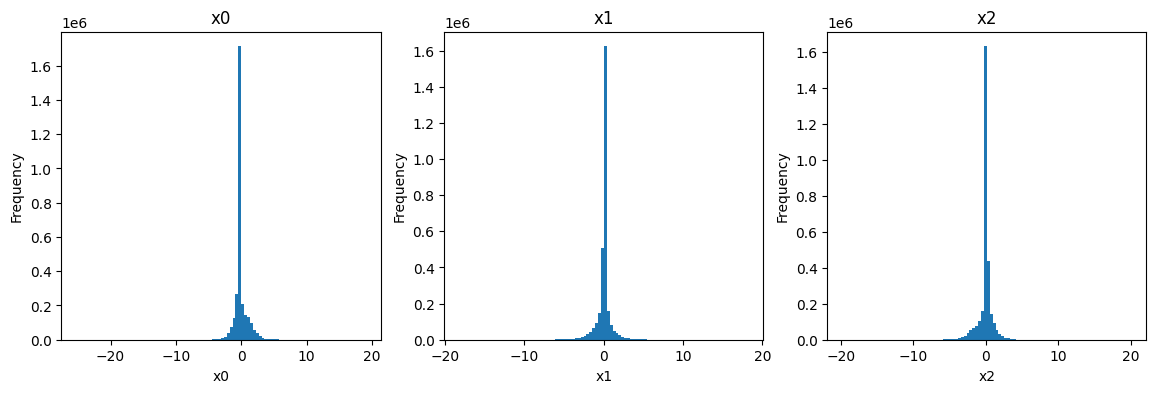

In [4]:
ocean_ds, ssh, params = preprocess_data(np.load(PATH_TO_FILE), TESTCASE, CONDI_NET, True, NORMALIZE_TYPE)
ut.plot_distribution_histogram(ocean_ds.X_input, 3)
print(ocean_ds.data.shape)
print(ocean_ds.X_input.shape)

In [5]:
sshBC = -ocean_ds.normalize['ssh']['mean'] / ocean_ds.normalize['ssh']['std']
uBC = -ocean_ds.normalize['u']['mean'] / ocean_ds.normalize['u']['std']
vBC = -ocean_ds.normalize['v']['mean'] / ocean_ds.normalize['v']['std']
print(sshBC, uBC, vBC)


-0.13089944 0.039507672 0.14766209


In [6]:
class Emulator():
    def __init__(self, model, sshBC, uBC, vBC):
        self.model = model
        self.sshBC = sshBC
        self.uBC = uBC
        self.vBC = vBC
    
    # Define the forward pass
    def forward(self, x, H, mask):
        dx_dt = self.model(x, H=H, mask=mask)
        dT = 300
        x_next = x + dx_dt * dT
        # apply boundary conditions: assign 0.12 values of x_next the the boundary pixels for the 1st channel
        # apply boundary conditions: assign 0.12 values of x_next to the boundary pixels for the 1st channel
        x_next = x_next.at[:, 0, :, 0].set(self.sshBC)
        x_next = x_next.at[:, -1, :, 0].set(self.sshBC)
        x_next = x_next.at[:, :, 0, 0].set(self.sshBC)
        x_next = x_next.at[:, :, -1, 0].set(self.sshBC)
        # apply boundary conditions: assign 0.24 values of x_next the the boundary pixels for the 2nd channel
        x_next = x_next.at[:, 0, :, 1].set(self.uBC)
        x_next = x_next.at[:, -1, :, 1].set(self.uBC)
        x_next = x_next.at[:, :, 0, 1].set(self.uBC)
        x_next = x_next.at[:, :, -1, 1].set(self.uBC)
        # apply boundary conditions: assign 0.36 values of x_next the the boundary pixels for the 2nd channel
        x_next = x_next.at[:, 0, :, 2].set(self.vBC)
        x_next = x_next.at[:, -1, :, 2].set(self.vBC)
        x_next = x_next.at[:, :, 0, 2].set(self.vBC)
        x_next = x_next.at[:, :, -1, 2].set(self.vBC)

        return x_next
    
       

In [7]:
from typing import Union, List

def run_simulation(initial_state, emulator, H_bathy, mask, further_step: Union[int, List[int]] = 1):
    assert isinstance(further_step, (int, list)), "further_step must be either an integer or a list"
    further_step = [further_step] if isinstance(further_step, int) else further_step
    emulator.model.eval()
    states = []
    state = initial_state.clone()       
    # for step in further_step:
    for i, step in enumerate(further_step):
        # print(f"Rollout step: {step}")
        if i == 0 and step == 0:
            states.append(state)
            continue
        # Simplify the loop by directly using the last state if available
        if i == 0 and step > 0:
            for _ in range(step):
                state = emulator.forward(state, H=H_bathy, mask=mask)
            states.append(state)
        elif i > 0:
            for j, val in enumerate(range(further_step[i]-further_step[i-1])):
                state = emulator.forward(state, H=H_bathy, mask=mask)
            states.append(state)
    print("len(states): ", len(states))
    return torch.cat(states, dim=0)

(1, 1, 100, 100)
(1, 3, 100, 100)


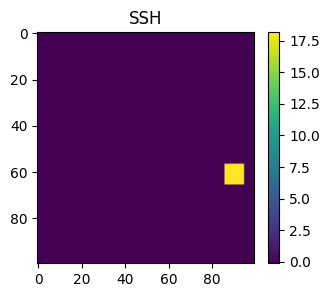

In [8]:
# simulation swe with autoregressive model for 10 time steps
# create H0 with jax array
H0 = jnp.array(ocean_ds.H[0:1])
mask0 = jnp.array(ocean_ds.maskBC[0:1])
x0 = jnp.array(ocean_ds.X_input[0:1])
params0 = jnp.array(params[0:1]) if params is not None else None

print(H0.shape)
print(x0.shape)
# plot x0 initial condition
plt.figure(figsize=(3.5, 3))
plt.subplot(1, 1, 1)
plt.imshow(x0[0, 0, :, :], aspect='auto')
plt.colorbar()
plt.title("SSH")
time_steps = 300
# emulator_sims = autoregressive(forward_model, x0, params0, H0, mask0, time_steps, folder_saving)
# emulator_sims = autoregressive(emulator, x0, params0, H0, mask0, time_steps, folder_saving)

In [9]:
emulator = Emulator(model, sshBC=sshBC, uBC=uBC, vBC=vBC)


In [10]:
params0

In [11]:
# move the 2nd dimension to the last dimension
x0 = np.moveaxis(x0, 1, -1)
H0 = np.moveaxis(H0, 1, -1)
mask0 = np.moveaxis(mask0, 1, -1)
print(x0.shape)
print(H0.shape)
print(mask0.shape)


(1, 100, 100, 3)
(1, 100, 100, 1)
(1, 100, 100, 1)


In [13]:
x_next = emulator.forward(x0, H0, mask0)
# print(variables)

AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'value'

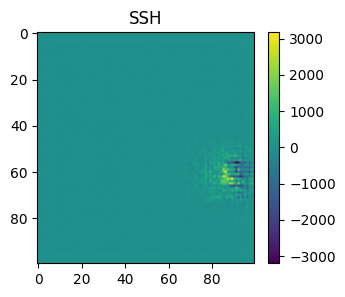

In [57]:
# plot x_next
plt.figure(figsize=(3.5, 3))
plt.subplot(1, 1, 1)
plt.imshow(x_next[0, :, :, 0], aspect='auto')
plt.colorbar()
plt.title("SSH")
plt.show()